# Метрики качества


"Что такое метрика?"

> Пусть задано некоторое множество K. 
Тогда метрикой этого множества называется такая функция $d$, что для 
любых x и y из этого множества выполняются следующие свойства:

>* $ d(x, y) = 0 <=> x = y $ (Тождество)
>* $ d(x, y) = d(y, x) $ (Симметрия)
>* $d(x, z) \le d(x, y) + d(y, z)$ (Неравенство треугольника)

Перед тем, как строить модели, хорошо бы понять, а как мы будем измерять качество их работы? 

Мы с вами будем работать с задачей бинарной классификации, то есть возможных вариантов целевой переменной может быть всего 2. Для наглядности предположим, что предсказываем беременность. 

В этом случае у нашего алгоритма может быть 4 варианта развития событий - предсказать беременность, когда она действительно есть, предсказать её отсутствие, когда её действительно нет, или совершить один из двух типов ошибок:

![](http://blog.exsilio.com/wp-content/uploads/2016/09/table-blog.png)

* Ошибка первого рода: мы предсказали человеку, что он беременен, а по факту нет.
* Ошибка второго рода: мы предсказали, что человек не беременен, а по факту - да.


![](https://miro.medium.com/max/3200/1*fSOPZZt8Bbm-lzNQhfqRLw.jpeg)



В разных задачах критичны разные виды ошибок. На основе этих ошибок можно придумать много метрик. 


### 1) Доля верно классифицированных объектов (Accuracy):

Берем всё, что предсказали правильно, делим на число всех наблюдений

$$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

Интуитивно понятная, очевидная и почти неиспользуемая метрика. Её главная проблема в том, что она бесполезна в задачах с неравными классами. Например, пусть у нас есть $50$ больных и $950$ здоровых. Мы хотим научиться их различать. Пусть наш алгоритм предсказывает, что все здоровы. В этом случае доля правильных ответов составит $95\%$, но алгорим окажется абсолютно бесполезным. 

Чтобы избежать таких эксцессов, а также учитывать, что разные типы ошибок могут иметь разную цену, строят другие две метрики: точность и полноту. 

### 2) Точность (Precision): 

$$P = \frac{TP}{TP + FP}$$

Отражает то, насколько мы можем доверять алгоритму, если он спрогнозировал единичку. 

### 3) Полнота (Recall): 

$$R = \frac{TP}{TP + FN}$$

Показывает, как много объектов первого класса наш алгоритм находит.

Введение precision не позволяет нам записывать все объекты в один класс, так как в этом случае мы получаем рост уровня False Positive. Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов.

Давайте составим для алгоритма из первого пункта матрицу ошибок и подсчитаем эти две метркии. Под классом $1$ будем понимать больных. Именно их мы хотели бы найти.  


|          | $y=1$ | $y=0$ |
|----------|-------|-------|
|$a(x) = 1$|  0    |  0    | 
|$a(x) = 0$|  50   |  950  | 


Точность будет равна нулю. Полнота тоже. Мы видим насколько алгоритм никчёмен. 

Более высокая точность влечёт более низкую полноту. Баланс между этими характеристиками выбирается в зависимости от задачи. В случае поиска больных, нам бы хотелось получить максимальную полноту. Не страшно, если здоровый сдаст анализы, страшно если мы пропустим больного. В задаче выдаче кредитов, наоборот, важнее точность.

Можно склеить эти две метрики, посчитав их среднее гармонческое и получить f-меру: 

### 4) F-measure: 

$$F = \frac{1}{\beta\frac{1}{P} + (1 - \beta)\frac{1}{R}}$$

Параметр $\beta$ в данном случае определяет вес точности в метрике. $\beta = 1$ вносит точность и полноту с одинаковыми весами. Изменяя его, можно отдавать предпочтения либо одному либо другому. 

Все эти метрики, конечно же, уже есть в пакете sklearn. 

```python
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
```

# Задача классификации. Метод ближайших соседей (kNN)

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 8]

import warnings
warnings.filterwarnings("ignore")

## KNN в задаче классификации

In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
X, y = datasets.make_blobs(n_samples = 1000, n_features = 2, random_state = 4, centers = 2, cluster_std = 2)
X[:5], y[:5]

(array([[9.13201464, 3.21030545],
        [6.99701422, 0.23384308],
        [8.88782582, 1.73978857],
        [8.84007328, 3.38556852],
        [6.2716091 , 5.93695867]]),
 array([0, 0, 1, 1, 1]))

In [3]:
def get_class_colour(class_label):
    return 'green' if class_label else 'blue'

In [11]:
def plot_points(X, y, new_points = None, new_prediction = None, nearest_points = None, file_name = None):
    plt.figure(figsize = (8, 8))
    plt.scatter(X[:, 0], X[:, 1], c = [get_class_colour(y_i) for y_i in y], s = 100, edgecolor = 'black', alpha = 0.3)
    
    if new_points is not None:
        plt.scatter(new_points[:, 0], new_points[:, 1], c = 'red', s = 100, edgecolor = 'red')
    
    if new_prediction is not None:
        plt.scatter(new_points[:, 0], new_points[:, 1], c = [get_class_colour(y_i) for y_i in new_prediction], s = 100, edgecolor = 'black')
        
    if nearest_points is not None:
        plt.scatter(nearest_points[:, 0], nearest_points[:, 1], c = 'red', s = 100, edgecolor = 'black')
    
    plt.title("Classification problem \n What is the color for the new (x1, x2) pair?")
    plt.xlabel("x1 (feature)")
    plt.ylabel("x2 (feature)")
    
    if file_name:
        plt.savefig(filename)

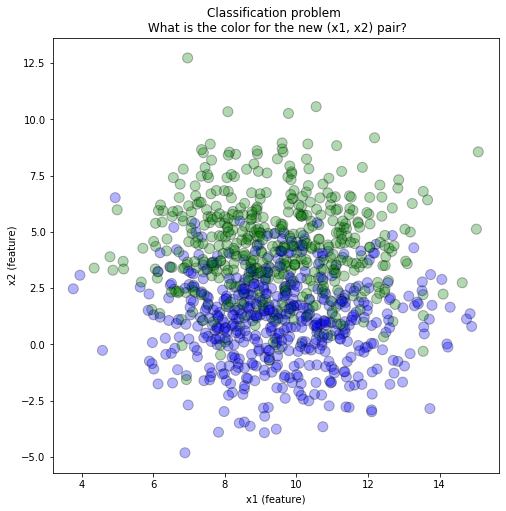

In [12]:
plot_points(X, y)

In [13]:
X_new = np.array([[12, 6]])

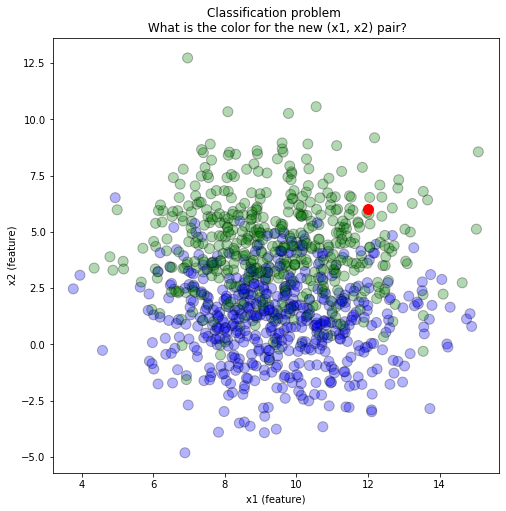

In [14]:
plot_points(X, y, new_points = X_new)

In [15]:
# Функция для вычисления евклидова пространства между новой точкой х_new и массивом точек X
from scipy.spatial.distance import euclidean

def find_nearest_point_index(x_new, X):
    d_min = euclidean(x_new, X[0])
    min_idx = 0
    for idx in range(1, X.shape[0]):
        d = euclidean(x_new, X[idx])
        if d < d_min:
            d_min = d
            min_idx = idx
    return min_idx


min_idx = find_nearest_point_index(X_new, X)

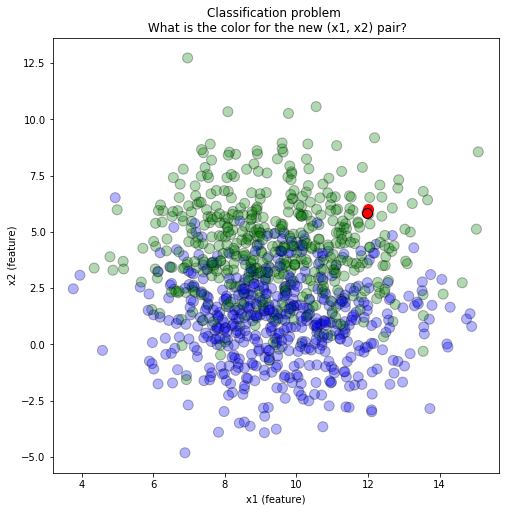

In [16]:
plot_points(X, y, new_points = X_new, nearest_points = X[[min_idx]])

In [17]:
def predict_class(x_new, X, y):
    min_idx = find_nearest_point_index(x_new, X)
    return y[min_idx]

y_new = predict_class(X_new, X, y)

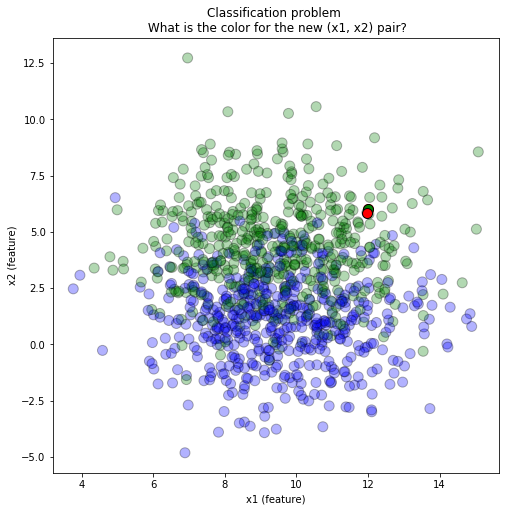

In [18]:
plot_points(X, y, new_points=X_new, new_prediction=[y_new], nearest_points=X[[min_idx]])

In [19]:
X_new = np.array([[12, -2]])
min_idx = find_nearest_point_index(X_new, X)
y_new = predict_class(X_new, X, y)

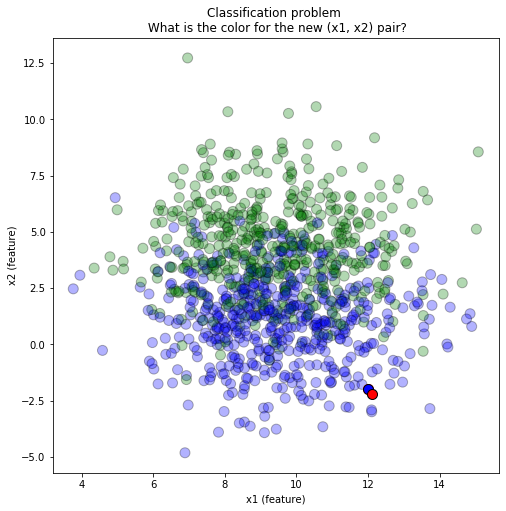

In [20]:
plot_points(X, y, new_points=X_new, new_prediction=[y_new], nearest_points=X[[min_idx]])

## Sklearn

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X, y)
y_pred = knn.predict(X_new)

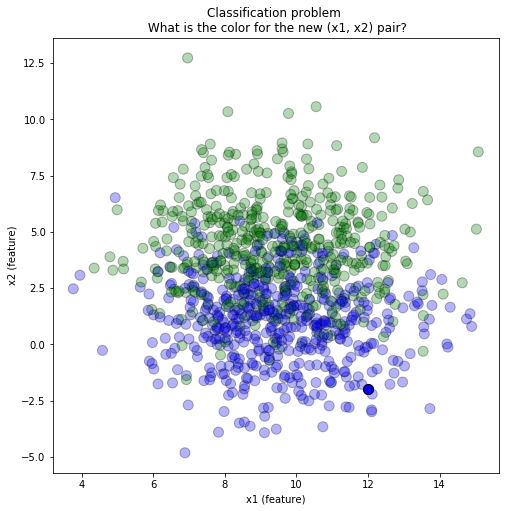

In [22]:
plot_points(X, y, new_points = X_new, new_prediction = [y_pred])

In [23]:
X_new = np.c_[np.random.randint(5, 15, 10), np.random.randint(-2, 8, 10)]

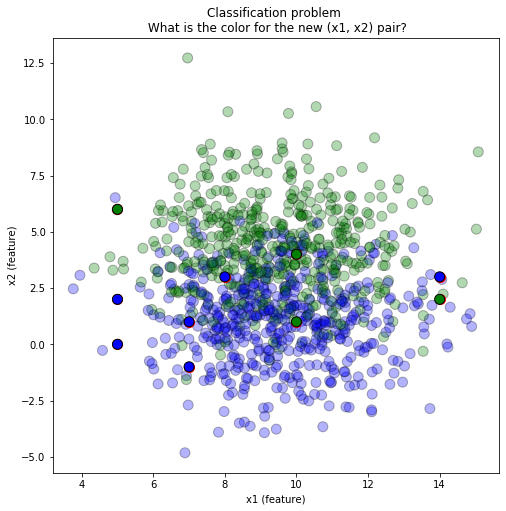

In [24]:
plot_points(X, y, new_points=X_new, new_prediction=knn.predict(X_new))

In [25]:
from scipy.spatial.distance import cdist
from collections import Counter

def predict_class(x_new, X, y, k=1):
    # cdist рассчитывает попарные расстояния между объектами
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    dist = cdist(x_new, X)
    
    # argpartition находит отсортированные индексы 
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.argpartition.html
    nearest_y = y[np.argpartition(dist, k, axis=1)[:, :k]]
    return np.array([Counter(row).most_common(1)[0][0] for row in nearest_y])

In [26]:
y_pred = predict_class(X_new, X, y, k=3)

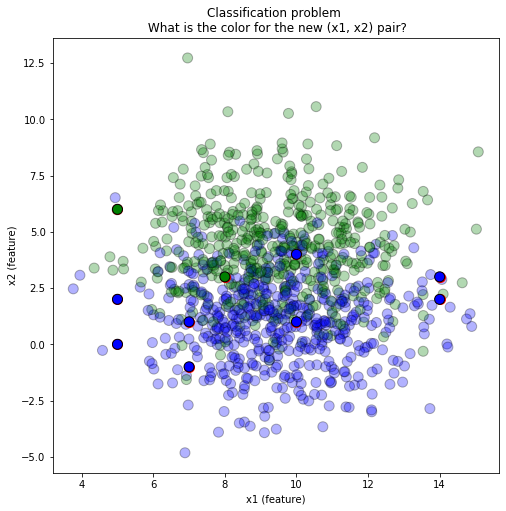

In [27]:
plot_points(X, y, new_points=X_new, new_prediction=y_pred)

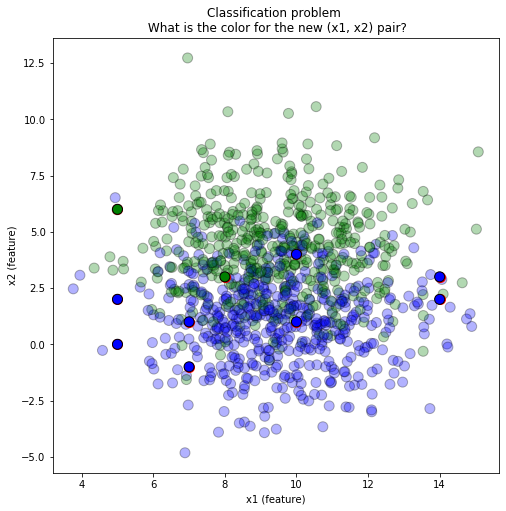

In [28]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)
y_pred = knn.predict(X_new)
plot_points(X, y, new_points=X_new, new_prediction=y_pred)

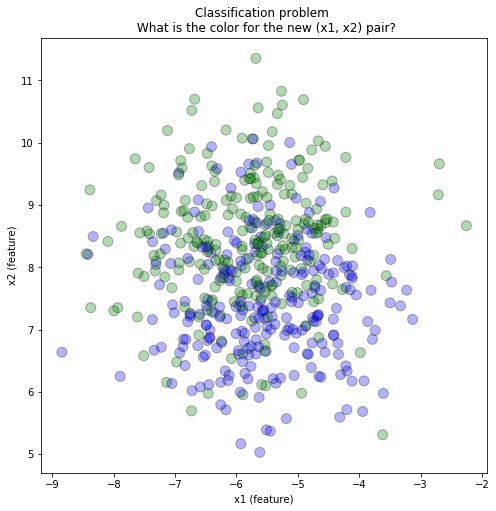

In [30]:
X, y = datasets.make_blobs(n_samples=500, random_state=5, centers=2)
plot_points(X, y)

# Влияние числа соседей k

In [31]:
h = .02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
x_pred = np.c_[xx.ravel(), yy.ravel()]

In [32]:
def plot_knn_classifier(k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    Z = knn.predict(x_pred)
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(12, 8))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.show()

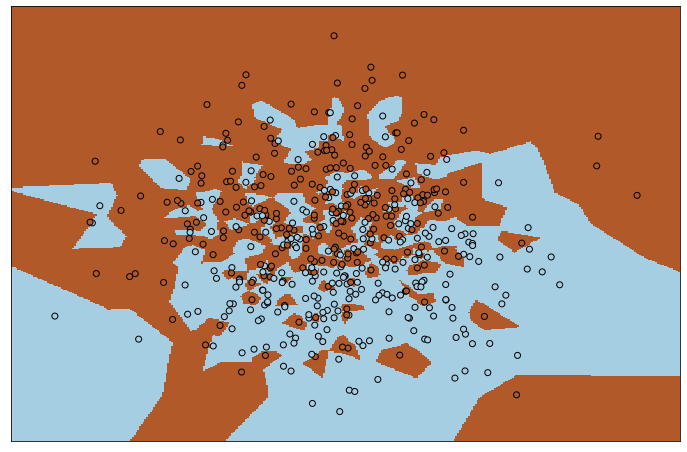

In [33]:
plot_knn_classifier(1)

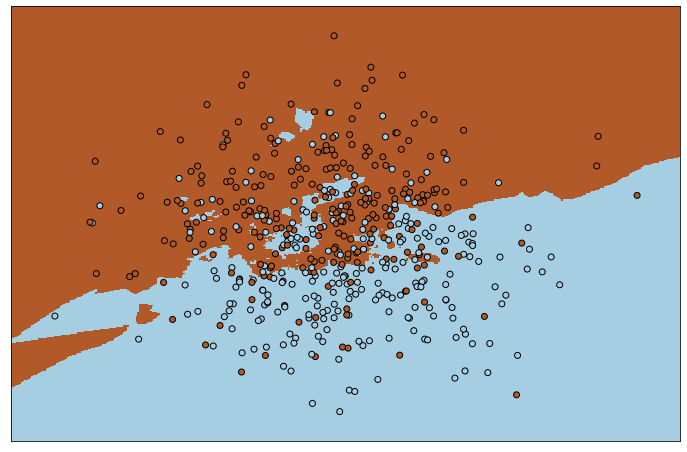

In [34]:
plot_knn_classifier(10)

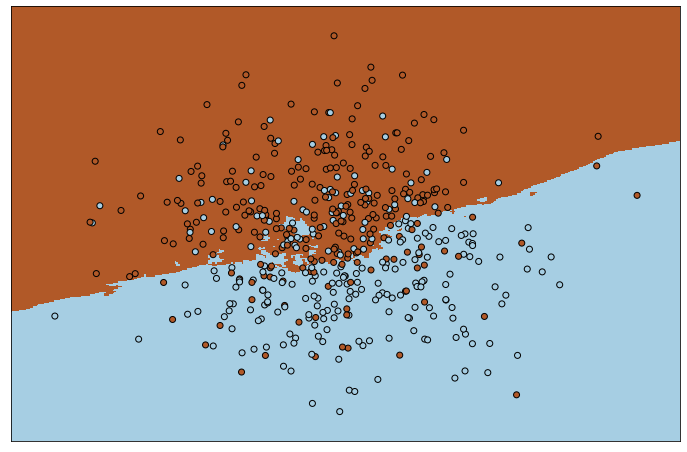

In [35]:
plot_knn_classifier(30)

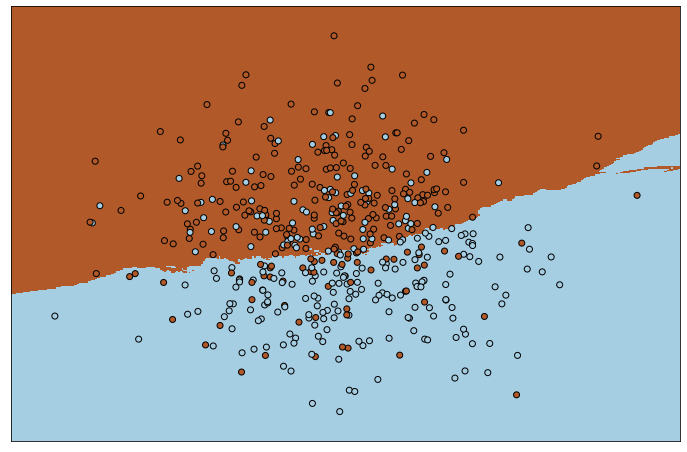

In [36]:
plot_knn_classifier(90)

# Нормализация данных в knn

In [88]:
X, y = datasets.make_blobs(n_samples = 125000, random_state = 4, centers = 2, cluster_std = 1.5)
X[:, 1] *= 1000000000
X[:5], y[:5]

(array([[8.51317034e+00, 3.72546741e+09],
        [6.43350940e+00, 3.47769034e+09],
        [8.53175178e+00, 1.59901849e+09],
        [9.26917945e+00, 5.53711291e+09],
        [7.68998149e+00, 1.50653096e+07]]),
 array([1, 1, 0, 1, 0]))

In [89]:
def plot_points_scaled(X, y, new_points = None, new_prediction = None, nearest_points = None, file_name  = None):
    plt.scatter(X[:, 0], X[:, 1], c = [get_class_colour(y_i) for y_i in y], s = 50, edgecolor = 'white', alpha = 0.3)
    plt.figure(1, figsize = (12, 8))
    plt.title("Classification problem \n What is the color for the new (x1, x2) pair?")
    plt.xlabel("x1 (feature)")
    plt.ylabel("x2 (feature)")
    plt.gca().set_aspect('equal', adjustable='datalim')
    if file_name:
        plt.savefig(filename)

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [91]:
def quality(prediction_y, true_y):
    accuracy = accuracy_score(prediction_y, true_y)
    precision = precision_score(prediction_y, true_y)
    recall = recall_score(prediction_y, true_y)
    f1 = f1_score(prediction_y, true_y)
    print("Accuracy:  {:.3f}\nPrecision: {:.3f}\nRecall:    {:.3f}\nF1-score:  {:.3f}".format(
        accuracy, precision, recall, f1
    ))

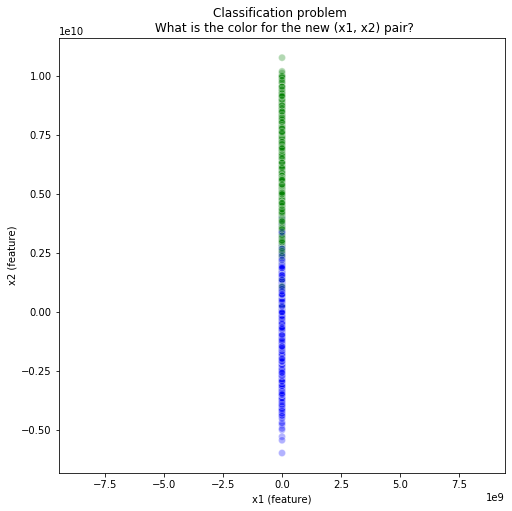

In [92]:
plot_points_scaled(X, y)

In [93]:
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X, y)
y_pred = knn.predict(X)
quality(y_pred, y)

Accuracy:  0.906
Precision: 0.905
Recall:    0.906
F1-score:  0.906


In [94]:
from sklearn.preprocessing import MinMaxScaler
X_scaled = MinMaxScaler().fit_transform(X)

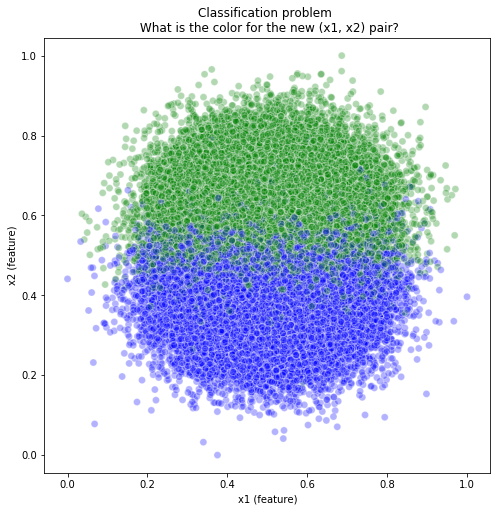

In [95]:
plot_points_scaled(X_scaled, y)

In [97]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_scaled, y)
y_pred = knn.predict(X_scaled)
quality(y_pred, y)

Accuracy:  0.906
Precision: 0.905
Recall:    0.906
F1-score:  0.906


# Выбор параметров модели

## Начинаем запутываться

**Testing set** - в самом начале работы откладываем часть данных и не используем их до внедрения модели в боевое окружение. Это наш финальный и самый верный способ проверить качество готовой модели. 

**Training set** - используется для непосредственной тренировки модели, эти данные модель "видит" во время обучения

**Validation set** - этот набор даннных модель "не видит" во время тренировки, но мы его используем для настройки гиперпараметров, то есть проверяем качество обученной модели и если мы им недовольны - меняем параметры модели и повторяем процедуру. Таким образом, модель хоть напрямую с этими данными и не работает, информацию из них мы всё равно многократно используем и она просачивается в модель в виде настроенных параметров. Т.е., качество модели на валидационной выборке может быть завышено. 


В `sklearn.model_selection` есть функция `train_test_split`, которая случайным (или не очень, если мы того хотим) образом делит выборку на две части. Вместо train и validation их чаще всего (на самом деле всегда) называют train и test, подразумевая, при этом, что истинная "тестовая" выборка хранится отдельно и будет использована в будущем после настройки модели.  

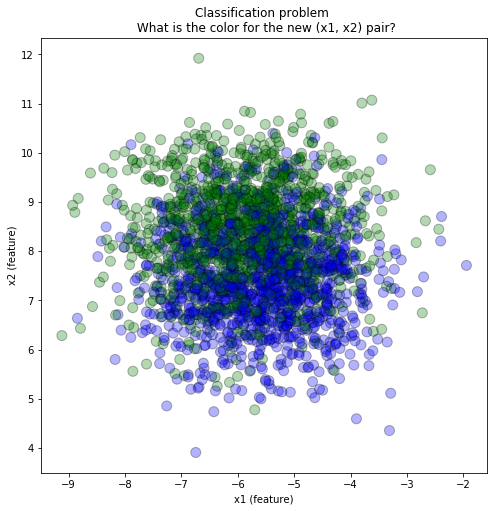

In [111]:
X, y = datasets.make_blobs(n_samples = 2500, random_state = 5, centers = 2)
plot_points(X, y)

In [112]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [113]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((1500, 2), (1000, 2), (1500,), (1000,))

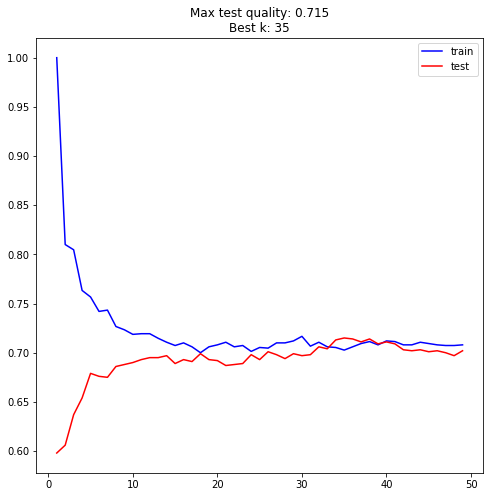

In [114]:
# проверяем качество модели KNN методом перебора гиперпараметра количества соседей, выберем для наглядности 
# количество соседей от 1 до 50, так как наблюдаемых точек много будет видно как модель будет ухудшаться с ростом количества соседей
neighbors = range(1, 50)
accuracy_train = []
accuracy_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    accuracy_train.append(accuracy_score(knn.predict(X_train), y_train))
    accuracy_test.append(accuracy_score(knn.predict(X_test), y_test))
    
plt.plot(neighbors, accuracy_train, color = 'blue', label = 'train')
plt.plot(neighbors, accuracy_test, color = 'red', label = 'test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(accuracy_test), np.argmax(accuracy_test)+1))
plt.legend()
plt.show()

((2100, 2), (1400, 2), (2100,), (1400,))

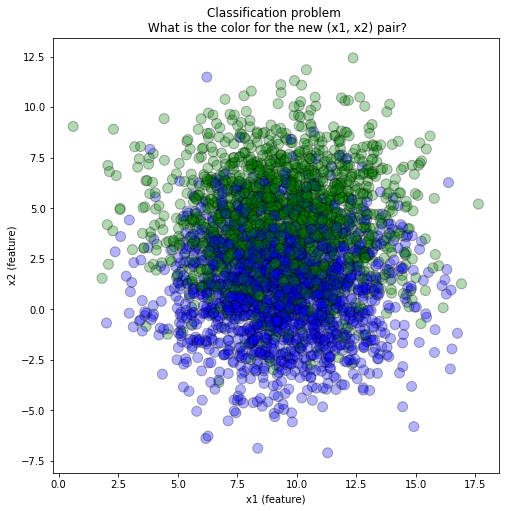

In [115]:
X, y = datasets.make_blobs(n_samples = 3500, random_state = 4, centers = 2, cluster_std = 2.5)
plot_points(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

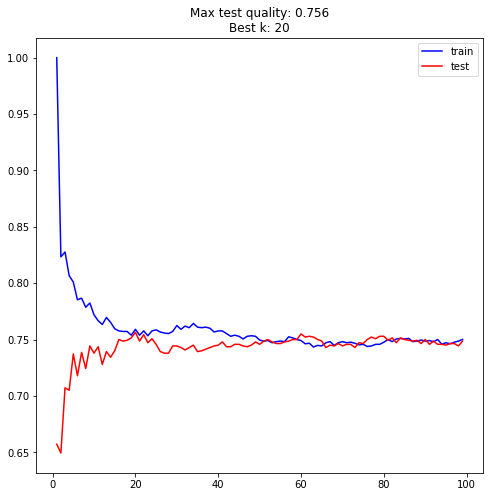

In [116]:
from sklearn.metrics import accuracy_score

neighbors = range(1, 100)
accuracy_train = []
accuracy_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy_train.append(accuracy_score(knn.predict(X_train), y_train))
    accuracy_test.append(accuracy_score(knn.predict(X_test), y_test))
    
plt.plot(neighbors, accuracy_train, color='blue', label='train')
plt.plot(neighbors, accuracy_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(accuracy_test), np.argmax(accuracy_test)+1))
plt.legend()
plt.show()

## Кросс-валидация (k-fold cross-validation)

Иногда данных не то чтобы очень много, а потестировать модель всё же хочется, да и получить устойчивые и надежные оценки качества модели - тоже не так плохо. 

Для такого случая была придумана очень полезная техника, использующася повсеместно - кросс-валидация. Наш изначальный датасет мы теперь будем делить не на train-validation-test, а на гораздо большее количество кусочков. В самом начале снова можно отложить тестовую выборку, на которой в самом конце мы проверим качество готовой модели. Далее берем оставшийся тренировочный датасет и делим его на папки (фолды, folds).

Например, задаём число фолдов равным 6 (обычно берется 3 или 5). Теперь мы делим нашу тренировочную выборку на 6 равных кусков. На пяти их них обучаем модель, на шестом - меряем качество. Теперь берем другое сочетание фолдов и снова повторяем обучение/тестирование. Продолжаем, пока каждый из фолдов не поучаствовал в тестировании. Таким образом, мы получаем столько оценок качества, сколько изначально задали фолдов, и столько же раз нам пришлось нашу модель обучать и тестировать. Теперь эти оценки мы можем усреднить, посчитать стандартное отклонение и узнать как, в среднем, ошибается наша модель и какие интервалы у этой ошибки. 

Вычислительно кросс-валидации крайне затратна, но если модель учится быстро, а датасет не сильно большой - это отличный способ получить "честные" оценки качества модели.

In [117]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors = 3)

scores = cross_val_score(knn, X, y, cv = 5, scoring = 'accuracy')
print(scores)
print('mean', scores.mean())
print('std', scores.std())

[0.70571429 0.71285714 0.71       0.70142857 0.71571429]
mean 0.7091428571428572
std 0.005078968238466063


# Тяжело в учении - легко в бою

https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients#_=_

Предсказание ортопедических проблем по измерениям костей таза и нижнего позвоночника. Быстро пройдемся по основным этапам работы с данными.

Загрузка - Статистики и Визуализация - Предобработка - Моделирование 

In [45]:
data = pd.read_csv('data/column_2C_weka.csv')

In [46]:
data.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [47]:
data.describe()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [48]:
data.isnull().sum()

pelvic_incidence            0
pelvic_tilt numeric         0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

## Распределение целевой переменной

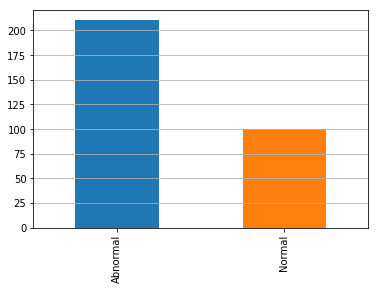

In [49]:
data['class'].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

In [50]:
data['class'].value_counts(normalize=True)

Abnormal    0.677419
Normal      0.322581
Name: class, dtype: float64

Здесь же можно прикинуть наш **baseline** качества, с которым можно будет сравнивать результаты работы модели. Если у нас 68% одного класса и 32% другого, то даже если наша модель будет предсказывать сплошные `Abnormal`, то `accuracy` будет равна, в среднем, 68%.

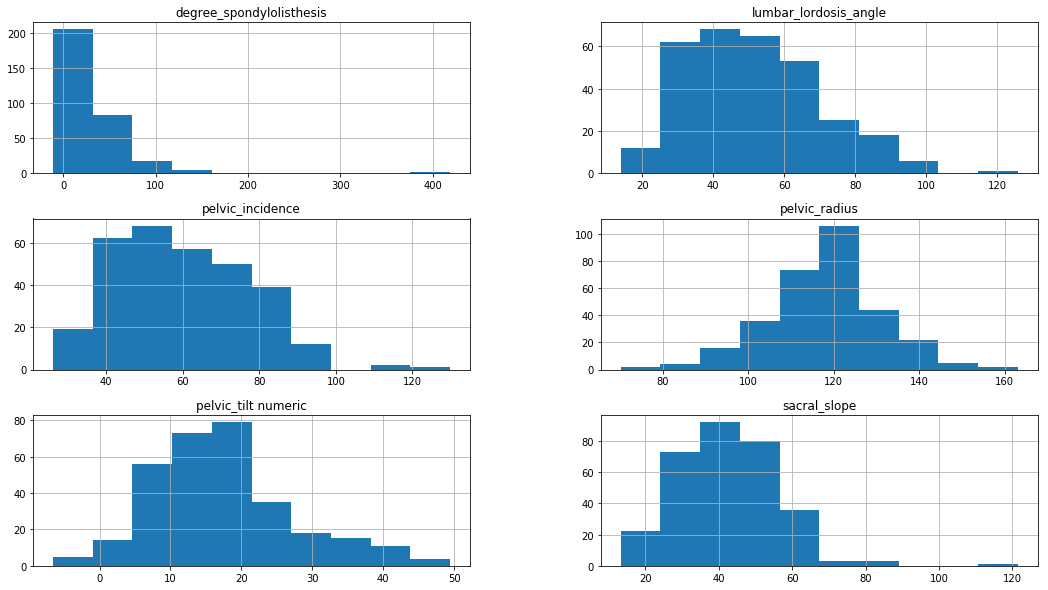

In [51]:
data.hist(figsize=(18, 10));

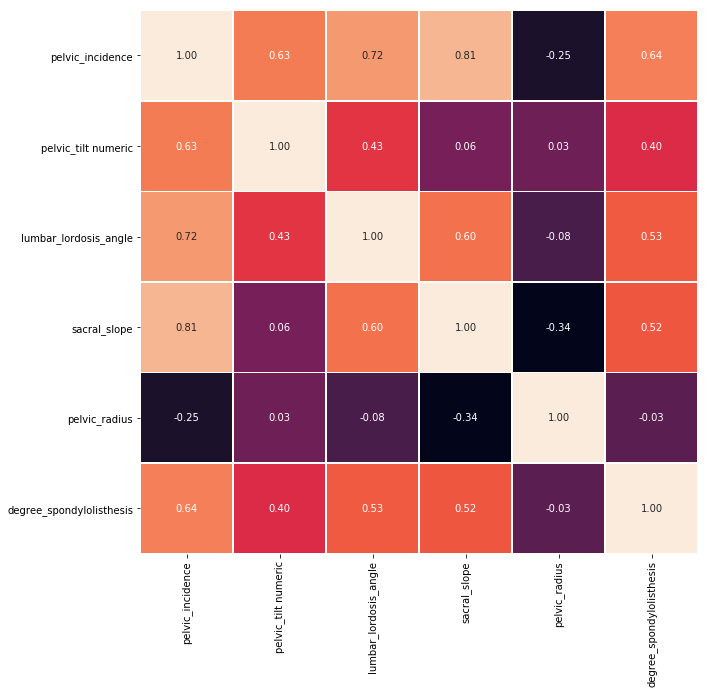

In [52]:
#correlation map
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

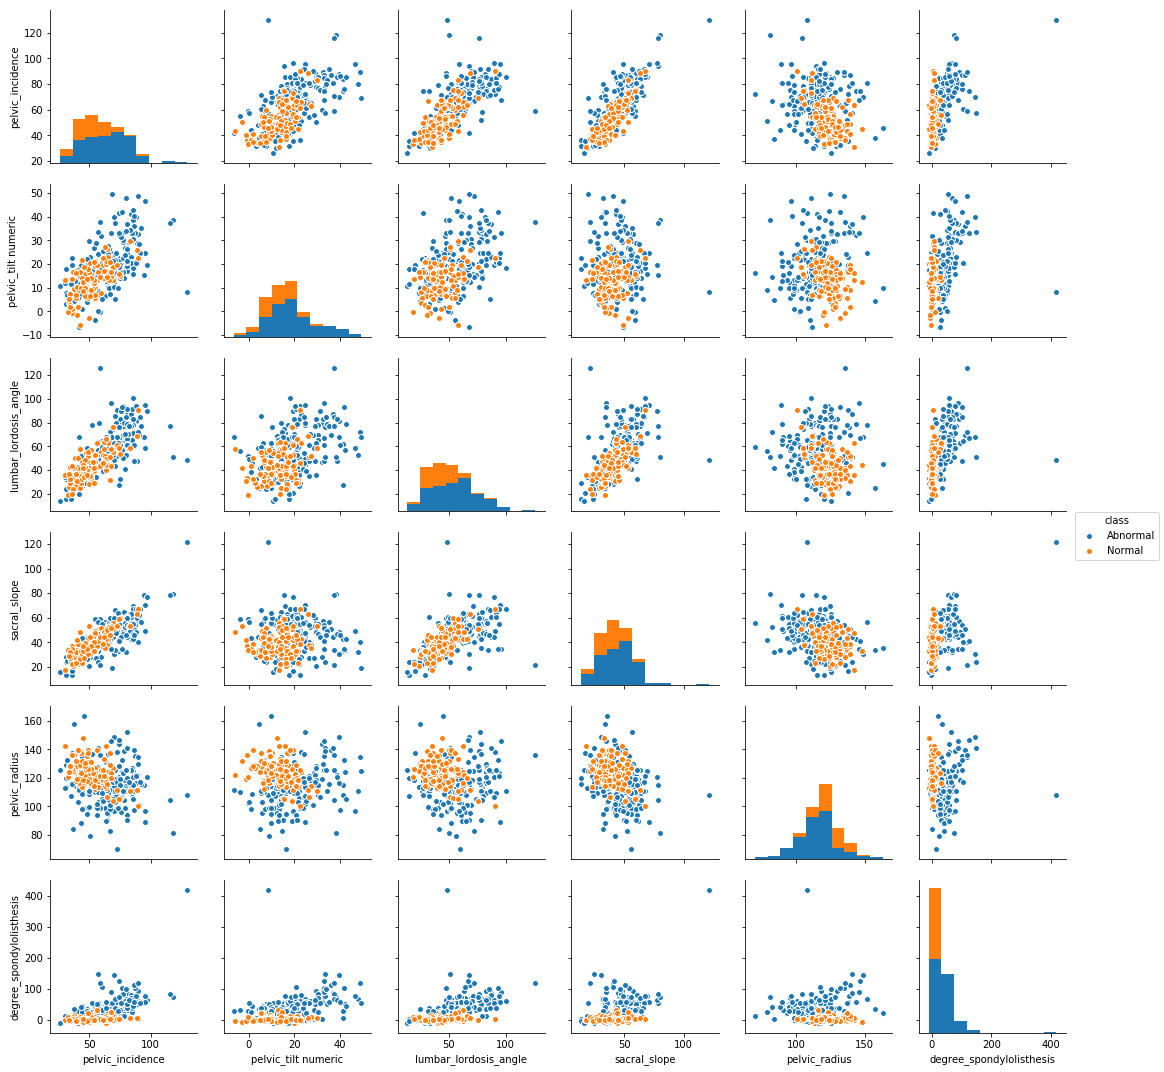

In [53]:
sns.pairplot(data, hue='class');

In [55]:
# plotly library
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
# import graph objects as "go"
import plotly.graph_objs as go

# creating trace1
trace1 =go.Scatter(
                    x = np.arange(0,310),
                    y = data[data['class']=='Normal'].sacral_slope,
                    mode = "markers",
                    name = "Normal",
                    marker = dict(color = 'rgba(0, 100, 255, 0.8)'),
                    text= data['class'])
# creating trace2
trace2 =go.Scatter(
                    x = np.arange(0,310),
                    y = data[data['class']=='Abnormal'].sacral_slope,
                    mode = "markers",
                    name = "Abnormal",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text= data['class'])

df = [trace1, trace2]
layout = dict(title = 'sacral_slope',
              xaxis= dict(title= 'index',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Values',ticklen= 5,zeroline= False)
             )
fig = dict(data = df, layout = layout)
iplot(fig)

## Перекодируем целевую

In [56]:
data['class'] = data['class'].apply(lambda x: 1 if x=='Abnormal' else 0)

In [57]:
data.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1


## Train-test split

Параметр `stratify` позволяет вам создавать такие разбиения, в которых распределения указанной переменной будут сохраняться. Очень полезно при дисбалансе классов, т.е. когда каких-то классов гораздо больше, чем других. 

Попробуйте ответить, почему? 

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['class'], axis=1), data['class'], test_size=0.20, random_state=42, stratify=data['class']
)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((248, 6), (62, 6), (248,), (62,))

In [60]:
y_train.value_counts(normalize=True)

1    0.677419
0    0.322581
Name: class, dtype: float64

In [61]:
y_test.value_counts(normalize=True)

1    0.677419
0    0.322581
Name: class, dtype: float64

## Scaling
### Важно! 
Учим на трейне - применяем на тесте. Практически все методы препроцессинга так или иначе используют информацию из выборки, например, при стандартизации считается среднее и дисперсия, значит, мы не хотим, чтобы информация из отложенной выборки просачивалась в тренировочную (data leak). 

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Подбор параметров разными способами

In [63]:
from sklearn.model_selection import cross_val_score

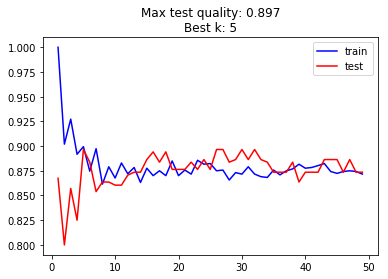

In [64]:
neighbors = range(1, 50)
f1_score_train = []
f1_score_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    f1_score_train.append(f1_score(knn.predict(X_train_scaled), y_train))
    f1_score_test.append(f1_score(knn.predict(X_test_scaled), y_test))
    
plt.plot(neighbors, f1_score_train, color='blue', label='train')
plt.plot(neighbors, f1_score_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(f1_score_test), np.argmax(f1_score_test)+1))
plt.legend();

## GridSearchCV

In [65]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
        'n_neighbors': range(1, 50),
        'p': range(1, 4)
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

print("Best CV score: {:.3f}, best CV k: {}".format(
    grid_search.best_score_, grid_search.best_estimator_.n_neighbors)
) 


test_predictions = grid_search.best_estimator_.predict(X_test_scaled)
print("Resulting test score: {:.3f}".format(f1_score(test_predictions, y_test)))

Best CV score: 0.885, best CV k: 33
Resulting test score: 0.886
CPU times: user 4.04 s, sys: 16.9 ms, total: 4.06 s
Wall time: 4.08 s


## RandomizedSearchCV

In [66]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_neighbors': range(1, 50),
    'p': range(1, 4)
}

knn = KNeighborsClassifier()

rand_search = RandomizedSearchCV(knn, param_grid, cv=5, scoring='f1', random_state=40)
rand_search.fit(X_train_scaled, y_train)

print("Best CV score: {:.3f}, best CV k: {}".format(
    rand_search.best_score_, rand_search.best_estimator_.n_neighbors)
) 

test_predictions = rand_search.best_estimator_.predict(X_test_scaled)
print("Resulting test score: {:.3f}".format(f1_score(test_predictions, y_test)))


Best CV score: 0.873, best CV k: 37
Resulting test score: 0.886
CPU times: user 524 ms, sys: 10.2 ms, total: 534 ms
Wall time: 543 ms


### Дополнительные материалы:
- http://www.machinelearning.ru/wiki/index.php?title=Метод_ближайших_соседей
- http://scikit-learn.org/stable/modules/neighbors.html
- http://bigdata-madesimple.com/k-nearest-neighbors-curse-dimensionality-python-scikit-learn/
- https://www.kaggle.com/skalskip/iris-data-visualization-and-knn-classification